# Hubble Diagram
In this notebook we are going to fit a cosmological model ($\Lambda$-CDM for the moment) to a set of luminosity distances $D_L$ and redshift $z$ data from simulated gravitational (GW) events. The data is representative of the expected 1-year observatiosn by Einstein Telescope (ET).

In [1]:
# read GW data
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM
from scipy.optimize import curve_fit

with h5py.File('nsns_population_joan.hdf5', 'r') as table:
    # print(table.keys())
    dl_unsorted = table['dL'][()]
    z_unsorted = table['z'][()]

In [2]:
# Get sorted indices based on array 'a'
sorted_indices = np.argsort(z_unsorted)

# Apply the sorting to both arrays
z = z_unsorted[sorted_indices]
dl = dl_unsorted[sorted_indices]
dl_err = 0.05*dl # 5% of actual value

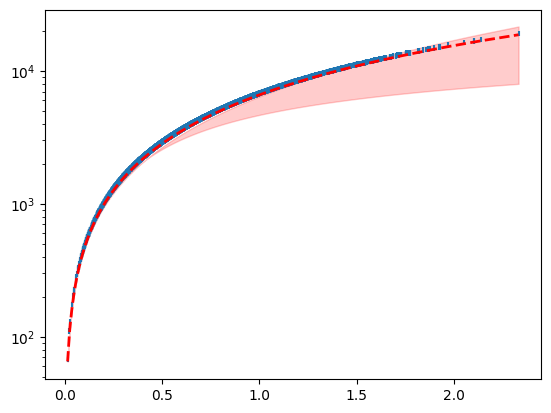

In [3]:
standard = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
upper = LambdaCDM(H0=70, Om0=2.0, Ode0=2.0)
lower = LambdaCDM(H0=70, Om0=0.0, Ode0=0.0)

plt.figure()
plt.errorbar(z, dl, dl_err, fmt='none')
plt.plot(z, standard.luminosity_distance(z), linewidth=2, c='r', linestyle='--')
plt.fill_between(z, lower.luminosity_distance(z).value, upper.luminosity_distance(z).value, color='r', alpha=0.2)
plt.yscale('log')

In [4]:
# Parameter ranges
Om = np.linspace(0.1, 2.0, 100)
Ode = np.linspace(0.1, 2.0, 100)

# Calculate chi-square surface
chi_surface = np.zeros([len(Om), len(Ode)])
mask = np.zeros([len(Om), len(Ode)])

factor = 1
extra = np.log10(factor)
total_err = dl_err + extra

def model(x, a, b):
    cosmo = LambdaCDM(H0=70, Om0=a, Ode0=b)
    return cosmo.luminosity_distance(x).value

popt, pcov = curve_fit(model, z, dl, p0=[1.0, 1.0], bounds=([0.0, 0.0], [2.0, 2.0]), sigma=total_err)
Om_fit, Ode_fit = popt

for i in range(len(Om)):
    for j in range(len(Ode)):
        cosmo = LambdaCDM(H0=70, Om0=Om[i], Ode0=Ode[j])
        model = cosmo.luminosity_distance(z).value
        if np.isnan(model).any():
            mask[i,j] = True
            chi_surface[i,j] = 1e4
            continue

        residuals = dl - cosmo.luminosity_distance(z).value
        dof = len(z)-2
        chi_surface[i,j] = np.sum((residuals/total_err)**2)/dof


masked_chi_surface = np.ma.array(chi_surface, mask=mask)

# Find best fit parameters
print(f"Best fit parameters: Om = {Om_fit:.2f}, Ode = {Ode_fit:.2f}")

min_chi = np.nanmin(masked_chi_surface)
Om_id, Ode_id = np.unravel_index(np.nanargmin(masked_chi_surface), masked_chi_surface.shape)
Om_manual_fit, Ode_manual_fit = Om[Om_id], Ode[Ode_id]
print(Om_manual_fit, Ode_manual_fit, min_chi)

/Users/joanalnu/opt/anaconda3/envs/grbcosmo/lib/python3.13/site-packages/astropy/cosmology/_src/flrw/base.py:1179: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]
/Users/joanalnu/opt/anaconda3/envs/grbcosmo/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2623: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*args, out=...)


Best fit parameters: Om = 0.34, Ode = 0.91
0.3303030303030303 0.906060606060606 0.016869684566436137


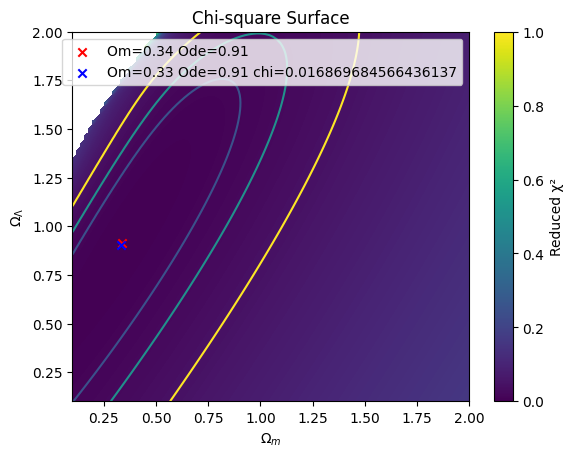

In [5]:
# Plot contour
plt.figure()
plt.contourf(Om, Ode, masked_chi_surface.T, levels=1000)
plt.contour(Om, Ode, masked_chi_surface.T, levels=[min_chi, min_chi+2.3, min_chi+4.61, min_chi+9.21])#, linestyles=['solid','dashed','dotted'])
plt.scatter(Om_fit, Ode_fit, marker='x', c='r', label=f'Om={Om_fit:.2f} Ode={Ode_fit:.2f}')
plt.scatter(Om_manual_fit, Ode_manual_fit, marker='x', c='b', label=f'Om={Om_manual_fit:.2f} Ode={Ode_manual_fit:.2f} chi={min_chi}')

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Chi-square Surface')
plt.colorbar(label='Reduced χ²')
plt.legend()
plt.show()

In [6]:
np.save('GW_chi_surface.npy', chi_surface)
np.save('GW_mask.npy', mask)